# Importing the data

## Import Libraries

In [20]:
# import system libraries
import os
import itertools
from PIL import Image
import cv2
from matplotlib.image import imread

# import data handling tools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# import Deep Learning Libraries
import tensorflow as tf
from tensorflow.keras import regularizers 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

figsize = (20, 8)
fontsize = 20
lablesize = 14

In [2]:
data_dir = 'Bird_Species_Dataset' 
#the code file should be in the same folder as the folder called 'Bird Species Dataset' thus this is the path to the folder containing the dataset
filepaths, image_list, label_list = [], [], []

folders = os.listdir(data_dir)

#print(folders)

for fold in folders:
    foldpath = os.path.join(data_dir, fold)
    flist = os.listdir(foldpath)
    for f in flist:
        fpath = os.path.join(foldpath, f)
        filepaths.append(fpath)
        label_list.append(fold)

print(filepaths)
print(label_list)

for file in filepaths:
    image = cv2.imread(file)
    image = img_to_array(image)
    image_list.append(image)
    
# Concatenate data paths with labels into one dataframe
Fseries = pd.Series(filepaths, name='filepaths')
Lseries = pd.Series(label_list, name='labels')
df = pd.concat([Fseries, Lseries], axis=1)

['Bird_Species_Dataset/AMERICAN GOLDFINCH/001.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/002.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/003.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/004.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/005.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/006.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/007.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/008.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/009.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/010.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/011.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/012.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/013.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/014.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/015.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/016.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/017.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/018.jpg', 'Bird_Species_Dataset/AMERICAN GOLDFINCH/019.jpg', 'Bird_Species_Dataset/AMERICAN

In [3]:
df['labels'].value_counts()

labels
AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
Name: count, dtype: int64

In [4]:
np.shape(image_list)

(811, 224, 224, 3)

### Plot bird-pictures

In [5]:
"""num_images = 6

# Get unique bird species labels
bird_species = df['labels'].unique()

# Set up the plot
plt.figure(figsize=(20, 20))

# Loop through each bird species
for idx, bird in enumerate(bird_species):
    # Filter the DataFrame to get file paths for this bird species
    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images
    
    # Loop through the 16 images and plot them
    for i, file in enumerate(bird_df['filepaths'].values):
        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)
        img = Image.open(file)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bird)
        
# Show the plot
plt.tight_layout()
plt.show()"""

"num_images = 6\n\n# Get unique bird species labels\nbird_species = df['labels'].unique()\n\n# Set up the plot\nplt.figure(figsize=(20, 20))\n\n# Loop through each bird species\nfor idx, bird in enumerate(bird_species):\n    # Filter the DataFrame to get file paths for this bird species\n    bird_df = df[df['labels'] == bird].sample(num_images)  # Get a random sample of 16 images\n    \n    # Loop through the 16 images and plot them\n    for i, file in enumerate(bird_df['filepaths'].values):\n        plt.subplot(len(bird_species), num_images, idx * num_images + i + 1)\n        img = Image.open(file)\n        plt.imshow(img)\n        plt.axis('off')\n        plt.title(bird)\n        \n# Show the plot\nplt.tight_layout()\nplt.show()"

### Splitting Data 

In [6]:
# Splitting dataset
strat = df['labels']
train_df, dummy_df = train_test_split(df, test_size=.3, shuffle=True, stratify=strat, random_state=123)

# valid and test dataframe
strat = dummy_df['labels']
valid_df, test_df = train_test_split(dummy_df, test_size=.5, shuffle=True, stratify=strat, random_state=123)


print(f"Number of Training dataset: {len(train_df)}\nNumber of Validation dataset: {len(valid_df)}\nNumber of Testing dataset: {len(test_df)}")

# NOTE: stratify = strat -> equal proportions of bird-labels in each data-substet (Train/Test/Val) as original data 

Number of Training dataset: 567
Number of Validation dataset: 122
Number of Testing dataset: 122


### ImageDataGenerator()-THING, FIND GOOD TITLE

In [7]:
# crobed image size
batch_size = 8
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical', 
                                       color_mode='rgb', shuffle= True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)


print(tr_gen)

Found 567 validated image filenames belonging to 6 classes.


Found 122 validated image filenames belonging to 6 classes.
Found 122 validated image filenames belonging to 6 classes.


### Images Structure

In [8]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

## CNN function

In [ ]:

def CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons):
    model = Sequential([
        Conv2D(n_filters, (n_conv,n_conv), activation='relu', padding='same', input_shape = img_shape, kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool,n_pool)),

        Conv2D(n_filters * 2, (n_conv,n_conv), activation='relu', padding='same', kernel_regularizer=regularizers.l2(lmbd)),
        MaxPooling2D((n_pool,n_pool)),
        
        Flatten(),
        Dense(n_neurons, activation='relu', kernel_regularizer=regularizers.l2(lmbd)),
        Dense(class_count, activation='softmax')
    ]) 
    # WHAT; SHOULD I REALLY HAVE N_FILTER * 2 IN 2.CONV2D LAYER????????????????????????????
    
    model.compile(Adam(learning_rate = eta), loss = 'categorical_crossentropy', metrics=['acc'])
    # NOTES: 
    # INFO: tf.keras.Sequential   -> look at: https://www.tensorflow.org/api_docs/python/tf/keras/Sequential

    # compile(...,  loss = 'categorical_crossentropy')  -> Computes the crossentropy loss between the labels and predictions.
    
    return model




# -- If want to add Conv. or Pool. layer, then add:
# model.add(layers.Conv2D(n_filters, (n_conv, n_conv), input_shape=input_shape, padding='same', activation='relu', kernel_regularizer=regularizers.l2(lmbd)))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# maybe can include: 
#       Conv2D(16, (3,3), activation='relu', padding='same', kernel_regularizer=L2(lmd)),
#       MaxPooling2D((2,2)),

### Comparison $\lambda$ vs. $\eta$ with CNN model 

In [ ]:
# Set seed for reproducibility
seed = 2024
tf.keras.backend.clear_session()  # Clear any previous model session
tf.keras.utils.set_random_seed(seed)

# ------------------ Setting up parameters

# -------- Fixed Parameters trought project----
n_filters = 8
n_conv = 3
n_pool = 4
n_neurons = 50
# ---------------------------------------------


lmbd_list = np.logspace(-3,0,4)
lmbd_list[0] = 0 # setting first elemenent to include no L2-penalty
eta_list = np.logspace(-4,-1, 4)


print("lmbd = ", lmbd_list)
print("eta  = ", eta_list)



epochs = 10
batch_size = 10


CNN_model_list = []
fit_list       = []
for lmbd in lmbd_list:
    for eta in eta_list:
        # ---------------- Making model
        CNN_model = CNN(eta, lmbd, n_filters, n_conv, n_pool, n_neurons)
        print("------------------------- SUMMARY --------------------------")
        CNN_model.summary()

        # ---------------- Fitting to training data
        print(f'\n\n lmbd = {lmbd}, eta = {eta} \n')
        fit = CNN_model.fit(x= train_gen, epochs=epochs, batch_size=batch_size, validation_data=valid_gen, verbose=1) #, callbacks=[early_stopping, plateau])

        CNN_model_list.append(CNN_model)
        fit_list.append([fit, lmbd, eta])
        



lmbd =  [0.   0.01 0.1  1.  ]
eta  =  [0.0001 0.001  0.01   0.1   ]
------------------------- SUMMARY --------------------------
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 8)         0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 56, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 14, 14, 16)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 3136)              0   

### Performance Scores $\lambda$ vs. $\eta$

In [1]:
# ------------------------ Accuarcy Evolution
plt.figure(figsize=figsize)
plt.style.use('fivethirtyeight')

# Loop through fit_list to plot each fit's validation accuracy
for fit, lmbd, eta in fit_list: 
    tr_acc = fit.history['acc']
    val_acc = fit.history['val_acc']
    if val_acc[-1] < 0.5: #not plot if last accuracy < 0.5
        continue  

    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    acc_label = f'best epoch = {str(index_acc + 1)}'
    # Explenations: tr_ = training, val_ = validation



    #plt.plot(Epochs, tr_acc, label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, label= rf'$\lambda$ = {lmbd:g}, $\eta$ = {eta:g}')
    #plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)

plt.suptitle(r'CNN      -      Validation Accuracy   -   $\lambda$  vs. $\eta $', fontsize=fontsize)
plt.title(r"", fontsize=fontsize-5)
plt.xlabel('Epochs', fontsize=lablesize)
plt.ylabel('Accuracy', fontsize=lablesize)
plt.legend()

plt.tight_layout
#plt.savefig("CNN_plots/comparison_lmbd_eta_val_acc.png")
#plt.show()


# ----------------------------- Heatmap 
val_acc = [] # list with all accuracy scores for validation set
for fit, _, _ in fit_list:
    val_acc.append(fit.history['val_acc'][-1])

val_acc_heatmap = np.array(val_acc).reshape( (len(lmbd_list), len(eta_list)) )

# Find index for maximum val_acc
index_max_val_acc = np.argmax(val_acc_heatmap)
index_max_2d = np.unravel_index(index_max_val_acc, val_acc_heatmap.shape)

# Create heatmap
plt.figure(figsize=(8, 6))
plt.style.use('fivethirtyeight')

sns.heatmap(val_acc_heatmap, annot=True, cmap="coolwarm", xticklabels=lmbd_list, yticklabels=eta_list)
# Get the row and column to highlight highest accuracy
# Draw lines around the specified cell
row, col = index_max_2d
plt.vlines(col, row, row + 1, color='yellow', linewidth=2)  # Left vertical
plt.vlines(col + 1, row, row + 1, color='yellow', linewidth=2)  # Right vertical
plt.hlines(row, col, col + 1, color='yellow', linewidth=2)  # Bottom horizontal
plt.hlines(row + 1, col, col + 1, color='yellow', linewidth=2)  # Top horizontal

plt.suptitle(r'CNN      -      Validation Accuracy   -   $\lambda$  vs. $\eta $', fontsize=fontsize)
plt.title(r"", fontsize=fontsize-5)
plt.ylabel(r"Learning Rate,  $\eta$", fontsize = lablesize)
plt.xlabel(r"L2-penalty,  $\lambda$", fontsize = lablesize)






# ---------------------------- Selecting optimal fit for lmbd vs. eta (according to Validation Accuracy)
# Save CNN model & parameters for future use 
CNN_model = CNN_model_list[index_max_val_acc]
fit, lmbd, eta = fit_list[index_max_val_acc] 

val_acc_optimal = fit.history['val_acc'][-1]


print("--------- Optimal Fit (according to Validation Accuracy)--------------")
print(f"Accuracy(lmbd = {lmbd}, eta = {eta}) = {val_acc_optimal:.3f}")


# Define needed variables
tr_acc = fit.history['acc']
tr_loss = fit.history['loss']
val_acc = fit.history['val_acc']
val_loss = fit.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch = {str(index_loss + 1)}'
acc_label = f'best epoch = {str(index_acc + 1)}'



NameError: name 'plt' is not defined

### Comparison Activation Functions vs. Batch Size (M)  with CNN model 

In [ ]:
# Runnign CNN for different Act.func vs. M

### Performance Scores Activation Functions vs. Batch Size (M)

In [ ]:
# Plotting codes

## Performance Scores 
### Optimal $\lambda$, $\eta$, (should be Activation Functions, Batch Size (M), # Hidden Layers, # Hidden Nodes) 

#### Training & Validation - Cross Entropy Loss 

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

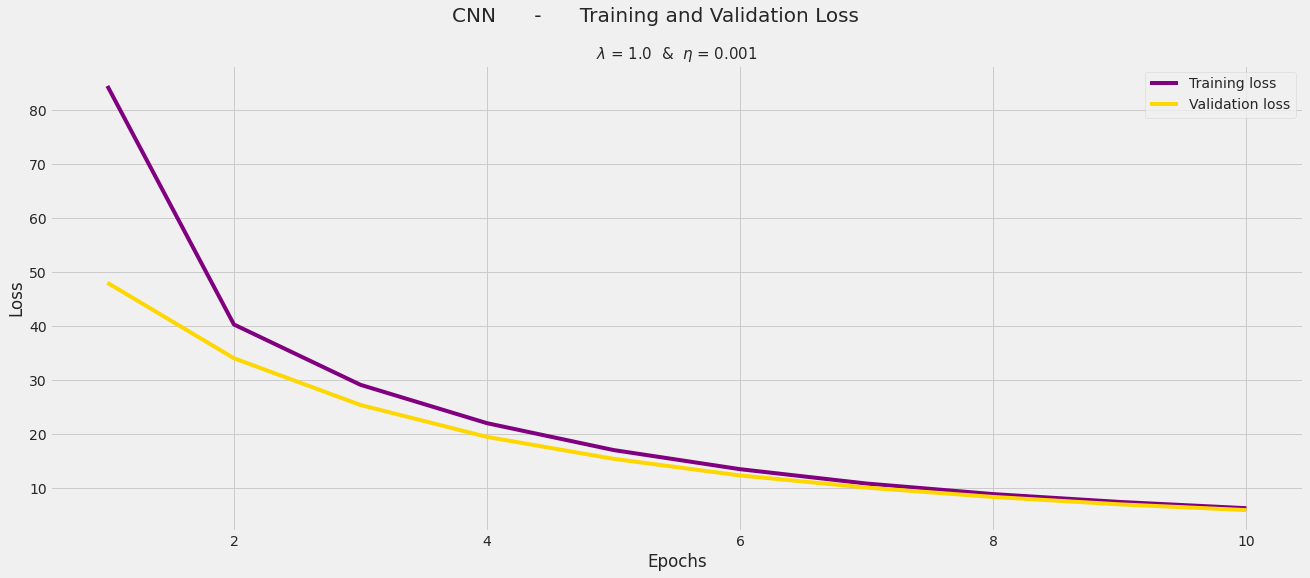

In [132]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_loss, 'purple', label= 'Training loss')
plt.plot(Epochs, val_loss, 'gold', label= 'Validation loss')
#plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'darkblue', label= loss_label)
plt.suptitle('CNN      -      Training and Validation Loss', fontsize=fontsize)
plt.title(rf'$\lambda$ = {lmbd}  &  $\eta$ = {eta}', fontsize=fontsize-5)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout
#plt.savefig("CNN_plots/train_val_loss.png")

#### Training & Validation - Accuracy

<function matplotlib.pyplot.tight_layout(*, pad=1.08, h_pad=None, w_pad=None, rect=None)>

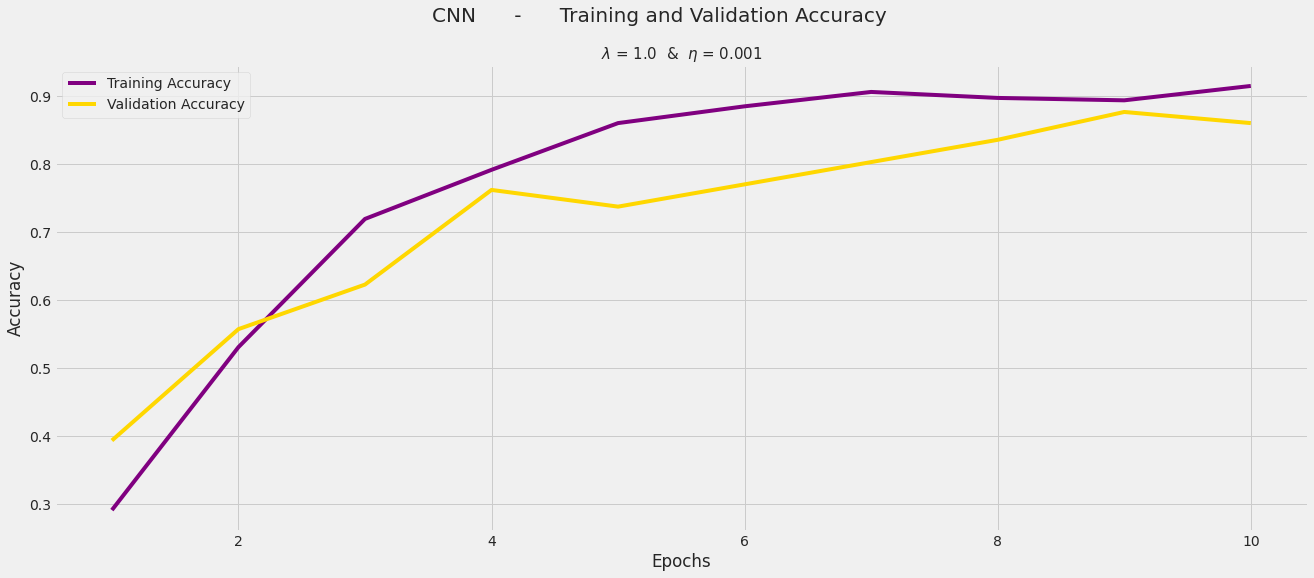

In [131]:
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.plot(Epochs, tr_acc, 'purple', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'gold', label= 'Validation Accuracy')
#plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'darkblue', label= acc_label)
plt.suptitle('CNN      -      Training and Validation Accuracy', fontsize=fontsize)
plt.title(rf'$\lambda$ = {lmbd}  &  $\eta$ = {eta}', fontsize=fontsize-5)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
#plt.savefig("CNN_plots/train_val_acc.png")

### Make Predictions

16/16 [==============================] - 0s 15ms/step


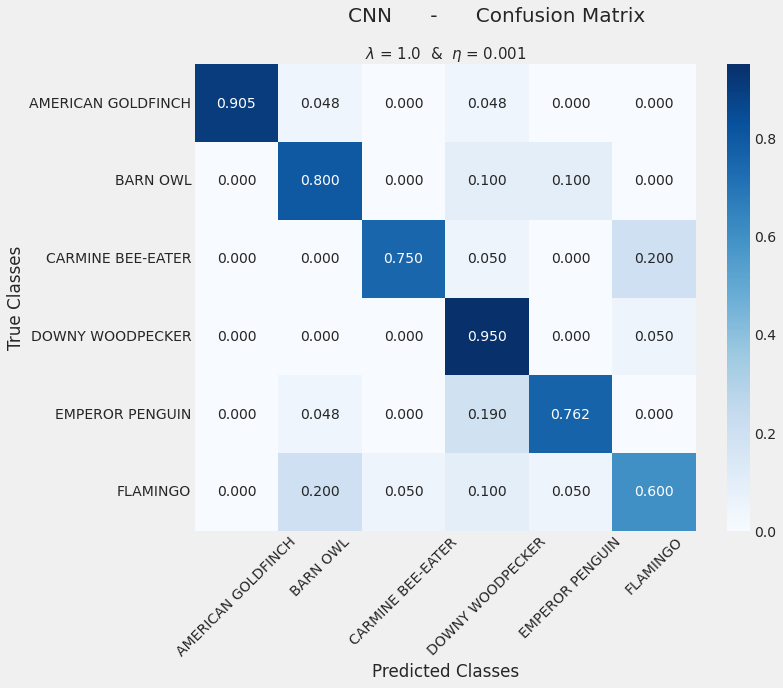

In [140]:
# Make Predictions
preds  = CNN_model.predict(test_gen) # Probabilities 6 labes   shape (122, 6)

y_pred = np.argmax(preds, axis=1)    # Most probable label     shape (122,)


# -------------------------.-- Plot Confusion matrix --------------------------------------
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred, normalize='true') 
# normalize = 'true' -> get respective accuracy scores  
# sum each row = 1 

# Create a heat map
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=classes, yticklabels=classes, fmt='.3f') #,  fmt='d')

plt.suptitle('CNN      -      Confusion Matrix', fontsize=fontsize)
plt.title(rf'$\lambda$ = {lmbd}  &  $\eta$ = {eta}', fontsize=fontsize-5)
plt.xlabel('Predicted Classes')
plt.ylabel('True Classes')

# Modify the rotation of axis labels
plt.xticks(rotation=45)  # Rotation of x-axis labels
plt.yticks(rotation=0)   # Rotation of y-axis labels
plt.show()




### Final Evaluation Model

In [141]:
# .evaluate gives list of score ["Cross_Entropy_Loss", "Accuracy"]????
train_score = CNN_model.evaluate(train_gen, verbose=1)
valid_score = CNN_model.evaluate(valid_gen, verbose=1)
test_score  = CNN_model.evaluate(test_gen, verbose=1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Valid Loss: ", valid_score[0])
print("Valid Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 0s 16ms/step - loss: 6.0984 - acc: 0.7951
Train Loss:  5.702305793762207
Train Accuracy:  0.9541445970535278
--------------------
Valid Loss:  5.928071022033691
Valid Accuracy:  0.8606557250022888
--------------------
Test Loss:  6.0984392166137695
Test Accuracy:  0.7950819730758667
